In [1]:
import skimage.io as sk
import pandas as pd
from torch.utils import data
import numpy as np

from torchvision import transforms
from PIL import Image
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using
print(torch.cuda.get_device_name(0))
def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv')
        label = pd.read_csv('train_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv')
        label = pd.read_csv('test_label.csv')
        return np.squeeze(img.values), np.squeeze(label.values)


class RetinopathyLoader(data.Dataset):
    def __init__(self, root,image_transform, mode):
        """
        Args:
            root (string): Root path of the dataset.
            mode : Indicate procedure status(training or testing)

            self.img_name (string list): String list that store all image names.
            self.label (int or float list): Numerical list that store all ground truth label values.
        """
        self.root = root
        self.img_name, self.label = getData(mode)
        self.image_transform = image_transform
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        """something you should implement here"""

        """
           step1. Get the image path from 'self.img_name' and load it.
                  hint : path = root + self.img_name[index] + '.jpeg'
           
           step2. Get the ground truth label from self.label
                     
           step3. Transform the .jpeg rgb images during the training phase, such as resizing, random flipping, 
                  rotation, cropping, normalization etc. But at the beginning, I suggest you follow the hints. 
                       
                  In the testing phase, if you have a normalization process during the training phase, you only need 
                  to normalize the data. 
                  
                  hints : Convert the pixel value to [0, 1]
                          Transpose the image shape from [H, W, C] to [C, H, W]
                         
            step4. Return processed image and label
        """
        path = self.root + '/'+ self.img_name[index] + '.jpeg'
        img = Image.open(f'{path}')
        gt_label = self.label[index]
        if self.image_transform :
            img = self.image_transform(img)
        
        return img, gt_label

C:\Users\bacoc\anaconda3\envs\resenv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


cuda
GeForce RTX 3060 Laptop GPU


In [2]:
#dataloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=4,
#                        shuffle=True, num_workers=0)

train_set = RetinopathyLoader(root='./data',mode='train',image_transform=image_transform)
train_loader = data.DataLoader(
    dataset=train_set, batch_size=4, shuffle=True)
for imgs, lbls in train_loader:
    print('Size of image:', imgs.size())  # batch_size * 3 * 224 * 224
    print('Type of image:', imgs.dtype)   # float32
    print('Size of label:', lbls.size())  # batch_size
    print('Type of label:', lbls.dtype)   # int64(long)
    break
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.



> Found 28099 images...
Size of image: torch.Size([4, 3, 512, 512])
Type of image: torch.float32
Size of label: torch.Size([4])
Type of label: torch.int64


Feature batch shape: torch.Size([4, 3, 512, 512])
Labels batch shape: torch.Size([4])


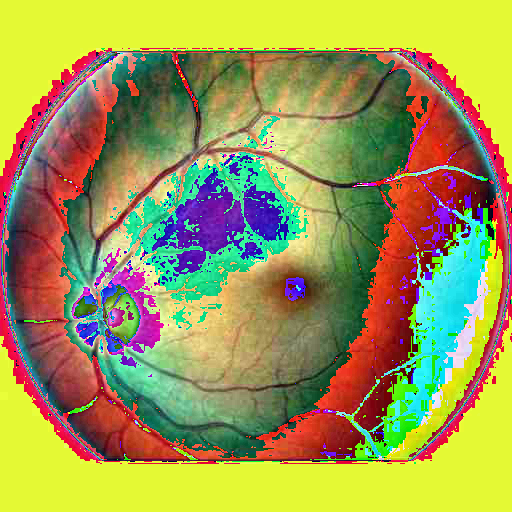

<PIL.Image.Image image mode=RGB size=512x512 at 0x25367EC6310>
(512, 512)


In [3]:
import matplotlib.pyplot as plt
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
im=transforms.ToPILImage()(img).convert("RGB")
display(im)
print(im)
print(im.size)

In [4]:
test_set = RetinopathyLoader(root='./data',mode='test',image_transform=image_transform)
test_loader = data.DataLoader(
    dataset=test_set, batch_size=4, shuffle=True)

> Found 7025 images...


In [5]:
from torchvision import models
import torch.nn as nn
#Since we've less data, we'll use Transfer learning.
model = models.resnet50(pretrained=True) #Downloads the resnet34 model which is pretrained on Imagenet dataset.&&

#Replace the Final layer of pretrained resnet34 with 4 new layers.
model.fc = nn.Sequential(nn.Linear(512,256),
                         nn.ReLU(inplace=True),
                         nn.Linear(256,128),
                         nn.ReLU(inplace=True),
                         nn.Linear(128,64),
                         nn.ReLU(inplace=True),
                         nn.Linear(64,5),    
                    )
print(model)
model = model.to(device) #Moves the model to the device.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    
    print(f'\nTraining Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [7]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    
    print(f'\nValidation Loss = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

In [8]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        valid_loss = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

In [9]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.
loss_fn   = nn.CrossEntropyLoss() #CrossEntropyLoss without class_weights.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4) 
nb_epochs = 5
#Call the optimize function.
train_losses, valid_losses = optimize(train_loader,test_loader,model,loss_fn,optimizer,nb_epochs)

cuda

Epoch 1/5
-------------------------------


C:\Users\bacoc\anaconda3\envs\resenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 6.00 GiB total capacity; 774.58 MiB already allocated; 11.36 MiB free; 796.00 MiB reserved in total by PyTorch)

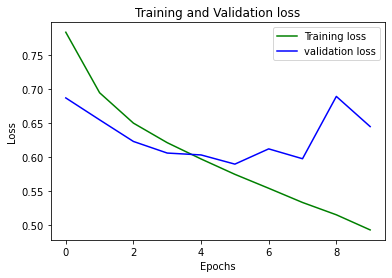

In [25]:
#https://www.kaggle.com/code/balajiai/diabetic-retinopathy-detection-using-pytorch/notebook reference
#Plot the graph of train_losses & valid_losses against nb_epochs.
epochs = range(nb_epochs)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
#Save the model
torch.save(model,'Res50_Pretrained.pth')

In [27]:
test_set = dataset(test_df,f'{path}test_images',image_transform = image_transform,train = False )

test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False) #DataLoader for test_set.

def test(dataloader,model):
    '''
    test function predicts the labels given an image batches.
    
    Args :
         dataloader: DataLoader for the test_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         
    Returns :
         List of predicted labels.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    labels = [] #List to store the predicted labels.
    
    with torch.no_grad():
        
        for batch,x in enumerate(dataloader):
            
            output = model(x.to(device))
            
            predictions = output.argmax(dim=1).cpu().detach().tolist() #Predicted labels for an image batch.
            labels.extend(predictions)
                
    print('Testing has completed')
            
    return labels

NameError: name 'dataset' is not defined